In [1]:
import sys
if '../' not in sys.path:
    sys.path.append('../')

import seaborn as sns
import pandas as pd
import numpy as np

from sklearn import metrics
from matplotlib import pyplot as plt

from src.clustering import KMeansSingleDimensionalClustererFinder, FisherJenksSingleDimensionalClustererFinder

In [2]:
data = pd.read_excel("../data/raw/ROS1_all data randomised.xlsx")
series = data["VALUE"].to_numpy()

### 1. Finding best clustering parameters using Davies-Boulding metric

Initialize Clusterer Finders

In [3]:
negated_davies_boulding = lambda *args, **kwargs: -metrics.davies_bouldin_score(*args, **kwargs)

MAX_K = 15

kmeans_clusterer_finder = KMeansSingleDimensionalClustererFinder(
    random_seed=35, 
    scoring_function=negated_davies_boulding,
    max_k=MAX_K
)

fj_clusterer_finder = FisherJenksSingleDimensionalClustererFinder(
    scoring_function=negated_davies_boulding,
    max_k=MAX_K
)

In [4]:
best_km_prediction = kmeans_clusterer_finder.cluster_data_series(series, verbose=True)

K: 2   Score: -0.37598351008126657
K: 3   Score: -0.3162188258549096
K: 4   Score: -0.29841483042114536
K: 5   Score: -0.36134987718761497
K: 6   Score: -0.4330617487902802
K: 7   Score: -0.4403377186471929
K: 8   Score: -0.4498677415942919
K: 9   Score: -0.4872832582455115
K: 10  Score: -0.48507687897531976
K: 11  Score: -0.46011679429776825
K: 12  Score: -0.4712599580265782
K: 13  Score: -0.4845318547892662
K: 14  Score: -0.490745977588149
K: 15  Score: -0.4945166606133816
Best K: 4
Best score: -0.29841483042114536


In [5]:
best_fj_labels = fj_clusterer_finder.cluster_data_series(series, verbose=True)

K: 2   Score: -0.37598351008126657
K: 3   Score: -0.3162188258549096
K: 4   Score: -0.29841483042114536
K: 5   Score: -0.36134987718761497
K: 6   Score: -0.43231352897206454
K: 7   Score: -0.43846397467181436
K: 8   Score: -0.4484094220229851
K: 9   Score: -0.4850329609275846
K: 10  Score: -0.48622355783959376
K: 11  Score: -0.46198139731521065
K: 12  Score: -0.4718003826162611
K: 13  Score: -0.4778251755779604
K: 14  Score: -0.4874272386423602
K: 15  Score: -0.4893154156105687
Best K: 4
Best score: -0.29841483042114536


Both Clusterer finders converge to the same prediction:

In [6]:
all(best_fj_labels == best_km_prediction)

True

Below we can see sizes of the clusters:

In [7]:
for label in set(best_fj_labels):
    print(f"Group {label}: {sum(best_fj_labels == label):>4} elements")

Group 0: 1738 elements
Group 1: 4896 elements
Group 2:   41 elements
Group 3:   13 elements


Different visualizations of clusters (intervals). Red lines denote breaks between different clusters.

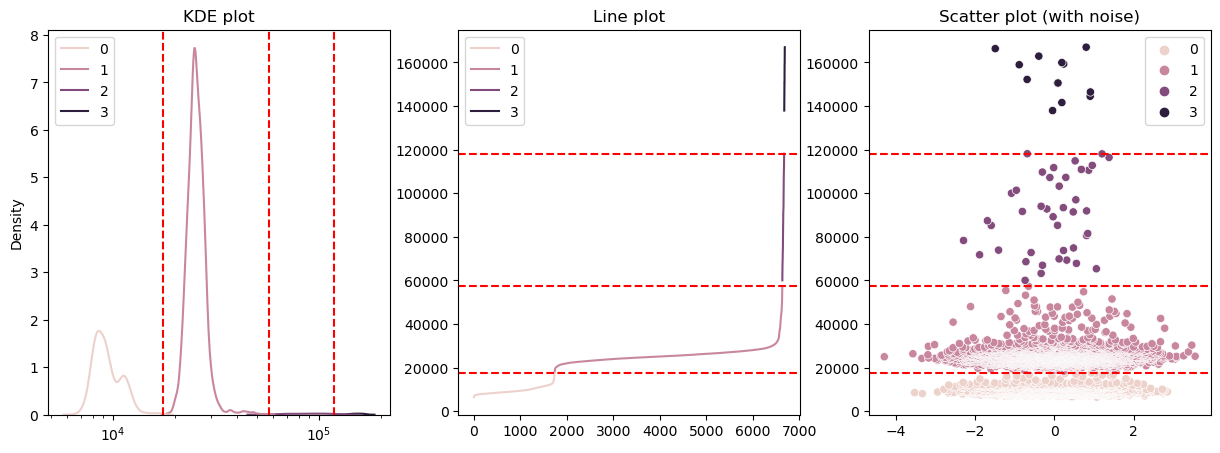

In [8]:
sorted_series = np.sort(series)
breaks = fj_clusterer_finder.best_clusterer.breaks_[1:-1]
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.kdeplot(x=sorted_series, hue=best_fj_labels ,ax=ax[0], log_scale=True).set_title("KDE plot")
sns.lineplot(x=range(len(series)), y=sorted_series, hue=best_fj_labels ,ax=ax[1]).set_title("Line plot")
sns.scatterplot(x=np.random.normal(size=(len(series), )), y=sorted_series, hue=best_fj_labels ,ax=ax[2]).set_title("Scatter plot (with noise)")
for b in breaks:
    ax[0].axvline(x=b, color='r', linestyle='--')
    ax[1].axhline(y=b, color='r', linestyle='--')
    ax[2].axhline(y=b, color='r', linestyle='--')
plt.show()

We can see that the group denoted by '1' is by far the most numerous.
Group '0' seems to have two local maxima.

KDE plot of the last two groups - distribution does not seem to be normal (probably due to small size of these 2 clusters)

Text(0.5, 1.0, 'KDE plot - focus on last 2 groups')

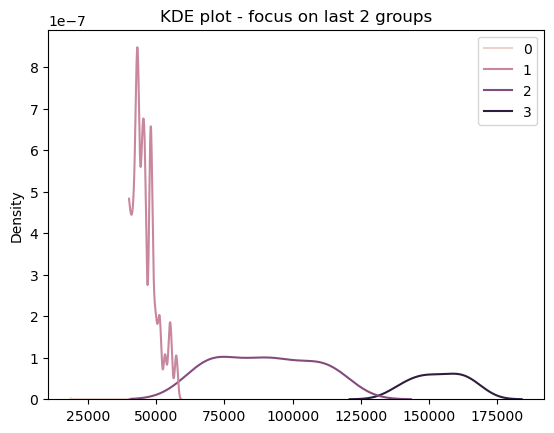

In [9]:
sns.kdeplot(x=sorted_series, hue=best_fj_labels , log_scale=False, clip=(40_000, 200_000)).set_title("KDE plot - focus on last 2 groups")

### 2. Finding best clustering parameters using Silhouette metric

In [10]:
MAX_K = 15

kmeans_clusterer_finder = KMeansSingleDimensionalClustererFinder(
    random_seed=35, 
    scoring_function=metrics.silhouette_score,
    max_k=MAX_K
)

fj_clusterer_finder = FisherJenksSingleDimensionalClustererFinder(
    scoring_function=metrics.silhouette_score,
    max_k=MAX_K
)

In [11]:
best_km_prediction = kmeans_clusterer_finder.cluster_data_series(series, verbose=True)

K: 2   Score: 0.9046650035322498
K: 3   Score: 0.8335119131501095
K: 4   Score: 0.835218835226262
K: 5   Score: 0.8382582096348212
K: 6   Score: 0.6356008994722809
K: 7   Score: 0.6372659727498718
K: 8   Score: 0.6132240201043159
K: 9   Score: 0.5607751638061009
K: 10  Score: 0.5724683281129647
K: 11  Score: 0.5714860820961398
K: 12  Score: 0.5619395413696702
K: 13  Score: 0.5624341036496997
K: 14  Score: 0.5554616793128768
K: 15  Score: 0.5581453273170782
Best K: 2
Best score: 0.9046650035322498


In [12]:
best_fj_labels = fj_clusterer_finder.cluster_data_series(series, verbose=True)

K: 2   Score: 0.9046650035322498
K: 3   Score: 0.8335119131501095
K: 4   Score: 0.835218835226262
K: 5   Score: 0.8382582096348212
K: 6   Score: 0.635746085903982
K: 7   Score: 0.6373572289021016
K: 8   Score: 0.6147339309856399
K: 9   Score: 0.5631426374283348
K: 10  Score: 0.573091546649468
K: 11  Score: 0.5731308401551142
K: 12  Score: 0.562587651080755
K: 13  Score: 0.5558242361880928
K: 14  Score: 0.5556909334327585
K: 15  Score: 0.56319867485543
Best K: 2
Best score: 0.9046650035322498


Once again both finders converge to the same prediction. Silhouette score was the best for only 2 groups.

In [13]:
all(best_fj_labels == best_km_prediction)

True

We can observe very high imbalance in the sizes of the two groups - outliers seem to have all been put to a single cluster.

In [14]:
for label in set(best_fj_labels):
    print(f"Group {label}: {sum(best_fj_labels == label):>4} elements")

Group 0: 6636 elements
Group 1:   52 elements


Visualization analogous to the one for DB score

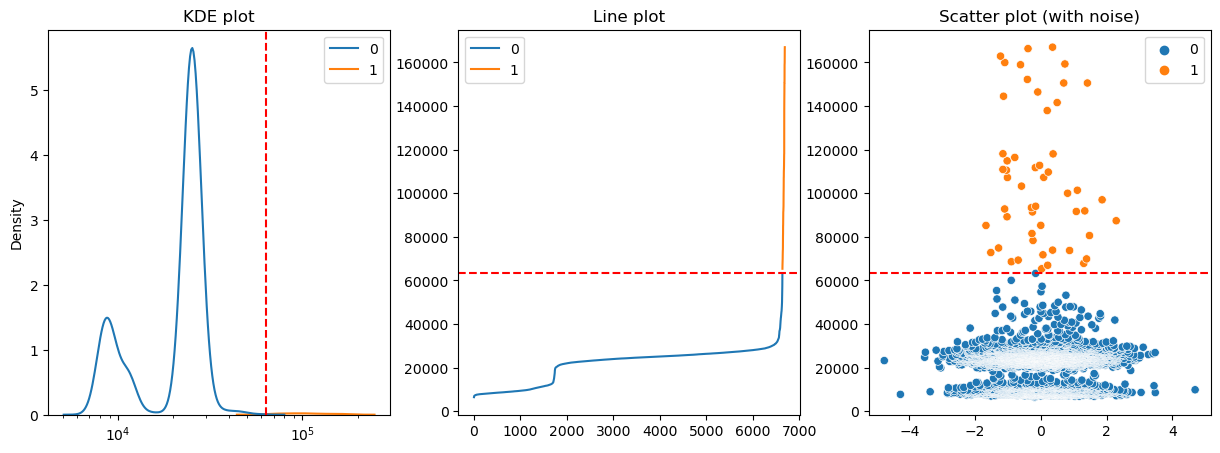

In [15]:
sorted_series = np.sort(series)
breaks = fj_clusterer_finder.best_clusterer.breaks_[1:-1]
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.kdeplot(x=sorted_series, hue=best_fj_labels ,ax=ax[0], log_scale=True).set_title("KDE plot")
sns.lineplot(x=range(len(series)), y=sorted_series, hue=best_fj_labels ,ax=ax[1]).set_title("Line plot")
sns.scatterplot(x=np.random.normal(size=(len(series), )), y=sorted_series, hue=best_fj_labels ,ax=ax[2]).set_title("Scatter plot (with noise)")
for b in breaks:
    ax[0].axvline(x=b, color='r', linestyle='--')
    ax[1].axhline(y=b, color='r', linestyle='--')
    ax[2].axhline(y=b, color='r', linestyle='--')
plt.show()

Overlapping region on KDE plot is due to smoothing.
Group '0' contains the vast majority of the examples.

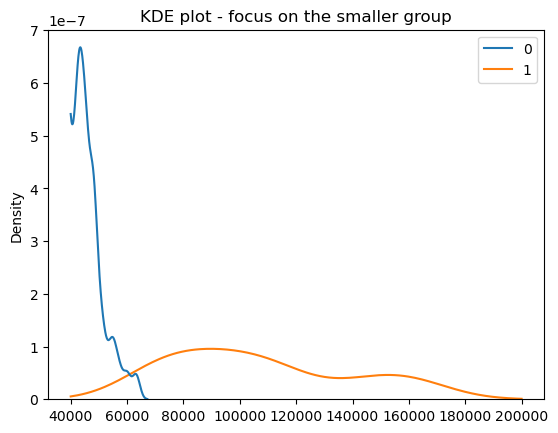

In [16]:
sns.kdeplot(x=sorted_series, hue=best_fj_labels , log_scale=False, clip=(40_000, 200_000)).set_title("KDE plot - focus on the smaller group")
plt.show()

### 3. Conclusion

- DB score seems to better suit our dataset due to its higher resiliance to outliers which there are a plenty of in the dataset.
- Outliers as well as the main body are both split into two groups according to DB score. 
- First group seem to also be splittable into two groups (as visible on KDE plot for DB score).
- Silhouette score could provide some better insight if data is stripped of the outliers.